In [13]:
from pyspark.sql import SparkSession, functions as F

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("BigDataProject_Nhom14").getOrCreate()

# Đọc dữ liệu từ HDFS (hoặc local)
df = spark.read.option("header", "true").option("inferSchema", "true") \
    .csv("hdfs://localhost:9000/doannhom14/mobile_ai_app_usage.csv")

# Tiền xử lý
df_clean = df.dropna()
df_clean = df_clean.filter(
    (F.col("age") >= 13) & (F.col("age") <= 60) &
    (F.col("usage_minute") >= 1) & (F.col("usage_minute") <= 120)
)
df_clean = df_clean.withColumn("user_rating", F.col("user_rating").cast("double"))
df_clean = df_clean.withColumn("usage_minute", F.col("usage_minute").cast("double"))
df_clean = df_clean.withColumn("age", F.col("age").cast("integer"))

# Tổng hợp đặc trưng theo user_id
user_features = df_clean.groupBy("user_id").agg(
    F.avg("usage_minute").alias("avg_minute"),
    F.avg("user_rating").alias("avg_rating"),
    F.sum(F.when(F.col("payment_type") == "Premium", 1).otherwise(0)).alias("n_premium"),
    F.countDistinct("app_name").alias("num_app_used")
)
user_features.show(5)


+--------+----------+----------+---------+------------+
| user_id|avg_minute|avg_rating|n_premium|num_app_used|
+--------+----------+----------+---------+------------+
|U_109015|      56.0|       3.3|        0|           1|
|U_490124|      51.0|       1.9|        0|           1|
|U_901115|      51.0|       4.9|        1|           1|
|U_638575|      33.0|       4.3|        1|           1|
|U_518648|      85.0|       1.3|        0|           1|
+--------+----------+----------+---------+------------+
only showing top 5 rows



In [14]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# 1. Vector hóa đặc trưng
assembler = VectorAssembler(
    inputCols=["avg_minute", "avg_rating", "n_premium", "num_app_used"],
    outputCol="features_raw"
)
user_vec = assembler.transform(user_features)

# 2. Chuẩn hóa
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(user_vec)
user_vec_scaled = scaler_model.transform(user_vec)

# 3. Phân cụm KMeans
kmeans = KMeans(k=3, seed=42, featuresCol="features")
kmeans_model = kmeans.fit(user_vec_scaled)
predictions = kmeans_model.transform(user_vec_scaled)

# 4. Đánh giá phân cụm
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette:.4f}")

# 5. Xem số user mỗi cụm
predictions.groupBy("prediction").count().show()

# 6. (Tùy chọn) Thống kê đặc trưng từng cụm
predictions.groupBy("prediction").agg(
    F.avg("avg_minute").alias("avg_minute"),
    F.avg("avg_rating").alias("avg_rating"),
    F.avg("n_premium").alias("avg_n_premium"),
    F.avg("num_app_used").alias("avg_num_app_used"),
    F.count("user_id").alias("num_users")
).show()


Silhouette Score: 0.2609
+----------+-----+
|prediction|count|
+----------+-----+
|         1|30212|
|         2|29669|
|         0|34874|
+----------+-----+

+----------+-----------------+------------------+-------------------+------------------+---------+
|prediction|       avg_minute|        avg_rating|      avg_n_premium|  avg_num_app_used|num_users|
+----------+-----------------+------------------+-------------------+------------------+---------+
|         1|93.00063440575488|3.6368236682996056| 0.1721501390176089|1.0046008208658812|    30212|
|         2|28.18628871886481|3.6572044895345606|0.16960463783747345|1.0041457413461863|    29669|
|         0|59.41111095180745|1.8874603333906532|0.27593622756208064|1.1282904169295176|    34874|
+----------+-----------------+------------------+-------------------+------------------+---------+



In [15]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Tạo label: 1 nếu dùng Premium, 0 nếu không
user_label = user_features.withColumn("label", (user_features.n_premium > 0).cast("integer"))

# Vector hóa đặc trưng
data = VectorAssembler(
    inputCols=["avg_minute", "avg_rating", "num_app_used"],
    outputCol="features"
).transform(user_label).select("features", "label")

# Train/test split
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)
model = rf.fit(train)
pred = model.transform(test)

# Đánh giá
auc = BinaryClassificationEvaluator(labelCol="label").evaluate(pred)
print(f"AUC: {auc:.2f}")


AUC: 0.52


In [16]:
# Nếu cần, hãy import pandas và seaborn
import pandas as pd

# Xuất kết quả về Pandas DataFrame (chỉ lấy 2 đặc trưng và cột 'prediction' - cụm)
pdf = predictions.select("avg_minute", "avg_rating", "prediction").toPandas()


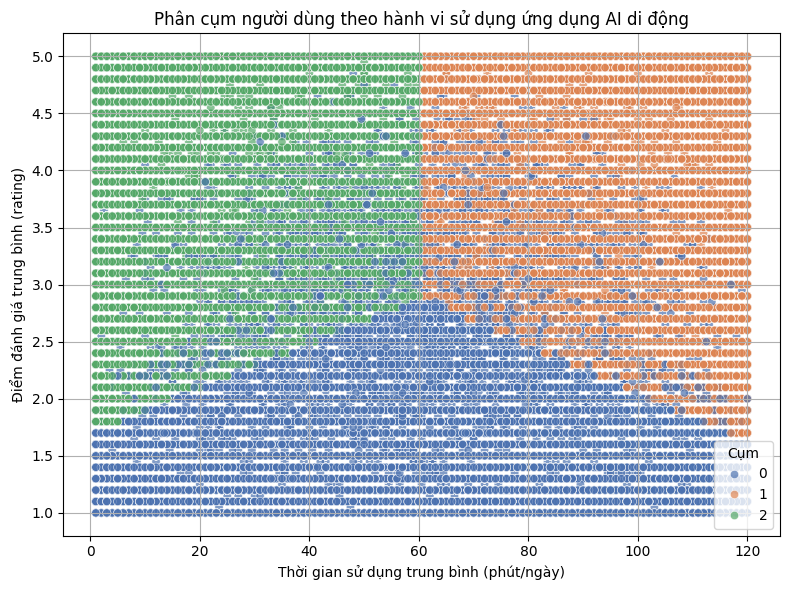

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pdf,
    x="avg_minute", y="avg_rating",
    hue="prediction", palette="deep", alpha=0.7
)
plt.title("Phân cụm người dùng theo hành vi sử dụng ứng dụng AI di động")
plt.xlabel("Thời gian sử dụng trung bình (phút/ngày)")
plt.ylabel("Điểm đánh giá trung bình (rating)")
plt.legend(title="Cụm")
plt.grid(True)
plt.tight_layout()
plt.show()
